## 1.2.3 MNIST

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import random
import argparse
from torch.utils.data import DataLoader, Subset, random_split
import os
import torch.nn as nn
import torch.optim as optim
from utils import plot_tsne

import Trainers
import classifiers as clf
import mnist_123 as autoencoders
#from mnist_123 import vae_loss

/home/kerenmizrahi/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kerenmizrahi/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Prep data

torch.Size([64, 1, 28, 28])
tensor(5)


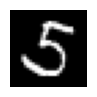

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

freeze_seeds(42)

# normalize data
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset_path = '/datasets/cv_datasets/data'
batch_size = 64

# Load MNIST from the given path
ds_train = datasets.MNIST(root=dataset_path, train=True, download=False, transform=transform)
ds_validation = datasets.MNIST(root=dataset_path, train=False, download=False, transform=transform)

# dataset split: 
# train + test (during training)
# validation

# Split  80% train  20% test
train_size = int(0.8 * len(ds_train))  
test_size = len(ds_train) - train_size  
ds_train, ds_test = random_split(ds_train, [train_size, test_size])

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)


# Example - [batch_size, 1, 28, 28]
for image, label in dl_train:
    print(image.shape)
    print(label[0])
    img = image[0].squeeze(0)  
    plt.figure(figsize=(1, 1))  
    plt.imshow(img.cpu().numpy(), cmap='gray')
    plt.axis('off')  
    plt.show()

    break


#### Model - 1.2.1 changed

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = autoencoders.Encoder_mnist().to(device)
decoder = autoencoders.Decoder_mnist().to(device)

loss_fn = nn.L1Loss() #  mean absolute error (reconstruction error) 
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001)
num_epochs = 10

trainer = Trainers.autoencoderTrainer(encoder, decoder, dl_train, dl_test, loss_fn, optimizer, num_epochs, device)
trainer.trainAutoencoder() 

import matplotlib.image as mpimg

plot_tsne(encoder, dl_test, "MNIST", device)

orig_img = 'image_tsne_mnist.png'
latent_img = 'latent_tsne_mnist.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(latent_img)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()

KeyboardInterrupt: 

In [5]:
classifier = clf.Classifier(input_size=).to(device) 

hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    'weight_decay' : 0.0,
    'learning_rate': 0.001,  
    'num_epochs': 5,            
}

freeze_encoder = True

trainer = clf.clfTrainer(classifier, encoder, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 64x64)

#### Model - VAE

In [5]:
from torch.nn import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

im_size = ds_train[0][0].shape
h_dim = 128 #latent space dimention
z_dim = 2

'''
# Hyperparams
h_dim=512,
z_dim=256,

'''

# Model
encoder = autoencoders.EncoderCNN(in_channels=im_size[0], out_channels=h_dim).to(device)
decoder = autoencoders.DecoderCNN(in_channels=h_dim, out_channels=im_size[0]).to(device)
vae = autoencoders.VAE(encoder, decoder, im_size, z_dim).to(device)
vae_dp = DataParallel(vae).to(device)

# Show model 
print(vae)

AssertionError: 

#### Train

In [ ]:
'''
more hyperparams
x_sigma2=0.0004,
learn_rate=0.0002,
betas=(0.9, 0.999),
'''

optimizer = optim.Adam(vae.parameters(), lr=learn_rate, betas=betas)

def loss_fn(x, xr, z_mu, z_log_sigma2):
    return autoencoder.vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)

trainer = VAETrainer(vae_dp, dl_train, dl_test, loss_fn, optimizer, num_epochs, device)
checkpoint_file = 'checkpoints/vae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')



